In [1]:
## Install the following libraries that will be used for this analysis if haven't already 

# !pip install pandas scikit-learn matplotlib seaborn

In [2]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("credit_risk_dataset.csv")
df

,UniqueID,Loan To Value,Branch ID,Age,Employment Type,DisbursalDate,State_ID,State,Employee_code_ID,Mobile Avl Flag,...,Number of Active Accounts,Number of Overdue Accounts,Current Balance Amount,Sanctioned Amount,Disbursed Amount,Instalment Amount,Number of Accounts Opened Last 6 Months,Number of Delinquencies Last 6 Months,Average Account Age,Number of Inquiries
0,537409,73.23,67,33,Self employed,26/09/2018,NaN,Nevada,1998,1,...,1.0,1,27600,50200,50200,1991,0,1,13,0
1,624493,88.48,67,25,Self employed,26/10/2018,NaN,Nevada,1998,1,...,0.0,0,0,0,0,31,0,0,8,1
2,518279,89.66,67,28,Self employed,19/09/2018,NaN,Nevada,1998,1,...,0.0,0,0,0,0,1347,0,0,21,0
3,510278,71.89,67,29,Salaried,16/09/2018,NaN,Nevada,1998,1,...,1.0,0,72879,74500,74500,0,0,0,2,0
4,490213,89.56,67,27,Self employed,05/09/2018,NaN,Nevada,1998,1,...,1.0,0,-41,365384,365384,0,0,0,56,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59472,650784,71.82,254,26,NaN,31/10/2018,NaN,Colorado,1998,1,...,NaN,0,53512,53512,53512,0,1,0,0,0
59473,473780,65.99,254,33,NaN,29/08/2018,NaN,Colorado,1998,1,...,NaN,0,155000,225000,225000,0,0,0,1,0
59474,617679,67.21,254,31,NaN,25/10/2018,NaN,Colorado,1998,1,...,NaN,0,22779,30000,30000,1600,0,0,9,0
59475,483987,48.59,254,52,NaN,31/08/2018,NaN,Colorado,1998,1,...,NaN,0,35895,35895,35895,0,1,0,0,0


In [4]:
# Modify column names for easier referencing

df.columns = [col.replace(" ", "_") for col in df.columns]
df.columns

Index(['UniqueID', 'Loan_To_Value', 'Branch_ID', 'Age', 'Employment_Type',
       'DisbursalDate', 'State_ID', 'State', 'Employee_code_ID',
       'Mobile_Avl_Flag', 'VoterID_Flag', 'FICO_Score', 'Number_of_Accounts',
       'Number_of_Active_Accounts', 'Number_of_Overdue_Accounts',
       'Current_Balance_Amount', 'Sanctioned_Amount', 'Disbursed_Amount',
       'Instalment_Amount', 'Number_of_Accounts_Opened_Last_6_Months',
       'Number_of_Delinquencies_Last_6_Months', 'Average_Account_Age',
       'Number_of_Inquiries'],
      dtype='object')

In [5]:
# Drop columns with identifiers and date because it won't be useful for this analysis
exclude_columns = ['UniqueID', 'Branch_ID', 'Employee_code_ID', 'DisbursalDate']
df.drop(columns=exclude_columns, inplace=True)

In [6]:
# Check for columns with missing data
df.isna().sum()

Loan_To_Value                                  0
Age                                            0
Employment_Type                             5851
State_ID                                   59477
State                                          0
Mobile_Avl_Flag                                0
VoterID_Flag                                   0
FICO_Score                                     0
Number_of_Accounts                             0
Number_of_Active_Accounts                    222
Number_of_Overdue_Accounts                     0
Current_Balance_Amount                         0
Sanctioned_Amount                              0
Disbursed_Amount                               0
Instalment_Amount                              0
Number_of_Accounts_Opened_Last_6_Months        0
Number_of_Delinquencies_Last_6_Months          0
Average_Account_Age                            0
Number_of_Inquiries                            0
dtype: int64

In [7]:
# "Employment_Type", "State_ID" and "Number_of_Active_Accounts" have missing values

# Drop column "State_ID" because entire column is empty
df.drop(columns=['State_ID'], inplace=True)

# I have the option to either drop records with missing "Number_of_Active_Accounts" and "Employment_Type" which is around 10% of total records or to impute them with median or mode values. 
# I'll proceed with imputation because to drop 10% of total records is quite significant.
df["Employment_Type"].fillna(df["Employment_Type"].mode()[0], inplace=True)
df["Number_of_Active_Accounts"].fillna(df["Number_of_Active_Accounts"].median(), inplace=True)

### Exploratory Data Analysis

In [8]:
# Descriptive statistics
df.describe()

,Loan_To_Value,Age,Mobile_Avl_Flag,VoterID_Flag,FICO_Score,Number_of_Accounts,Number_of_Active_Accounts,Number_of_Overdue_Accounts,Current_Balance_Amount,Sanctioned_Amount,Disbursed_Amount,Instalment_Amount,Number_of_Accounts_Opened_Last_6_Months,Number_of_Delinquencies_Last_6_Months,Average_Account_Age,Number_of_Inquiries
count,59477.000000,59477.000000,59477.0,59477.000000,59477.000000,59477.000000,59477.000000,59477.000000,5.947700e+04,5.947700e+04,5.947700e+04,5.947700e+04,59477.000000,59477.000000,59477.000000,59477.000000
mean,75.593176,35.903963,1.0,0.138070,585.624443,4.733258,2.035543,0.305009,3.204515e+05,4.308231e+05,4.301927e+05,2.040773e+04,0.749601,0.189351,15.810919,0.342384
std,11.367510,9.515087,0.0,0.344977,245.956712,6.292866,2.233445,0.734192,1.333628e+06,4.413813e+06,4.418896e+06,1.938349e+05,1.214930,0.522278,15.799641,0.934265
min,15.300000,18.000000,1.0,0.000000,11.000000,1.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,69.740000,28.000000,1.0,0.000000,496.000000,1.000000,1.000000,0.000000,2.000000e+03,1.397300e+04,1.250000e+04,0.000000e+00,0.000000,0.000000,5.000000,0.000000
50%,77.960000,35.000000,1.0,0.000000,681.000000,3.000000,1.000000,0.000000,3.185900e+04,5.990700e+04,5.779700e+04,1.932000e+03,0.000000,0.000000,13.000000,0.000000
75%,84.480000,43.000000,1.0,0.000000,743.000000,6.000000,3.000000,0.000000,1.811040e+05,2.900000e+05,2.858220e+05,7.802000e+03,1.000000,0.000000,21.000000,0.000000
max,95.000000,64.000000,1.0,1.000000,890.000000,453.000000,65.000000,23.000000,9.652492e+07,1.000000e+09,1.000000e+09,2.076655e+07,35.000000,20.000000,117.000000,28.000000


In [9]:
# For categorical columns
df.describe(include='object')

,Employment_Type,State
count,59477,59477
unique,3,20
top,Self employed,Louisiana
freq,33945,14820


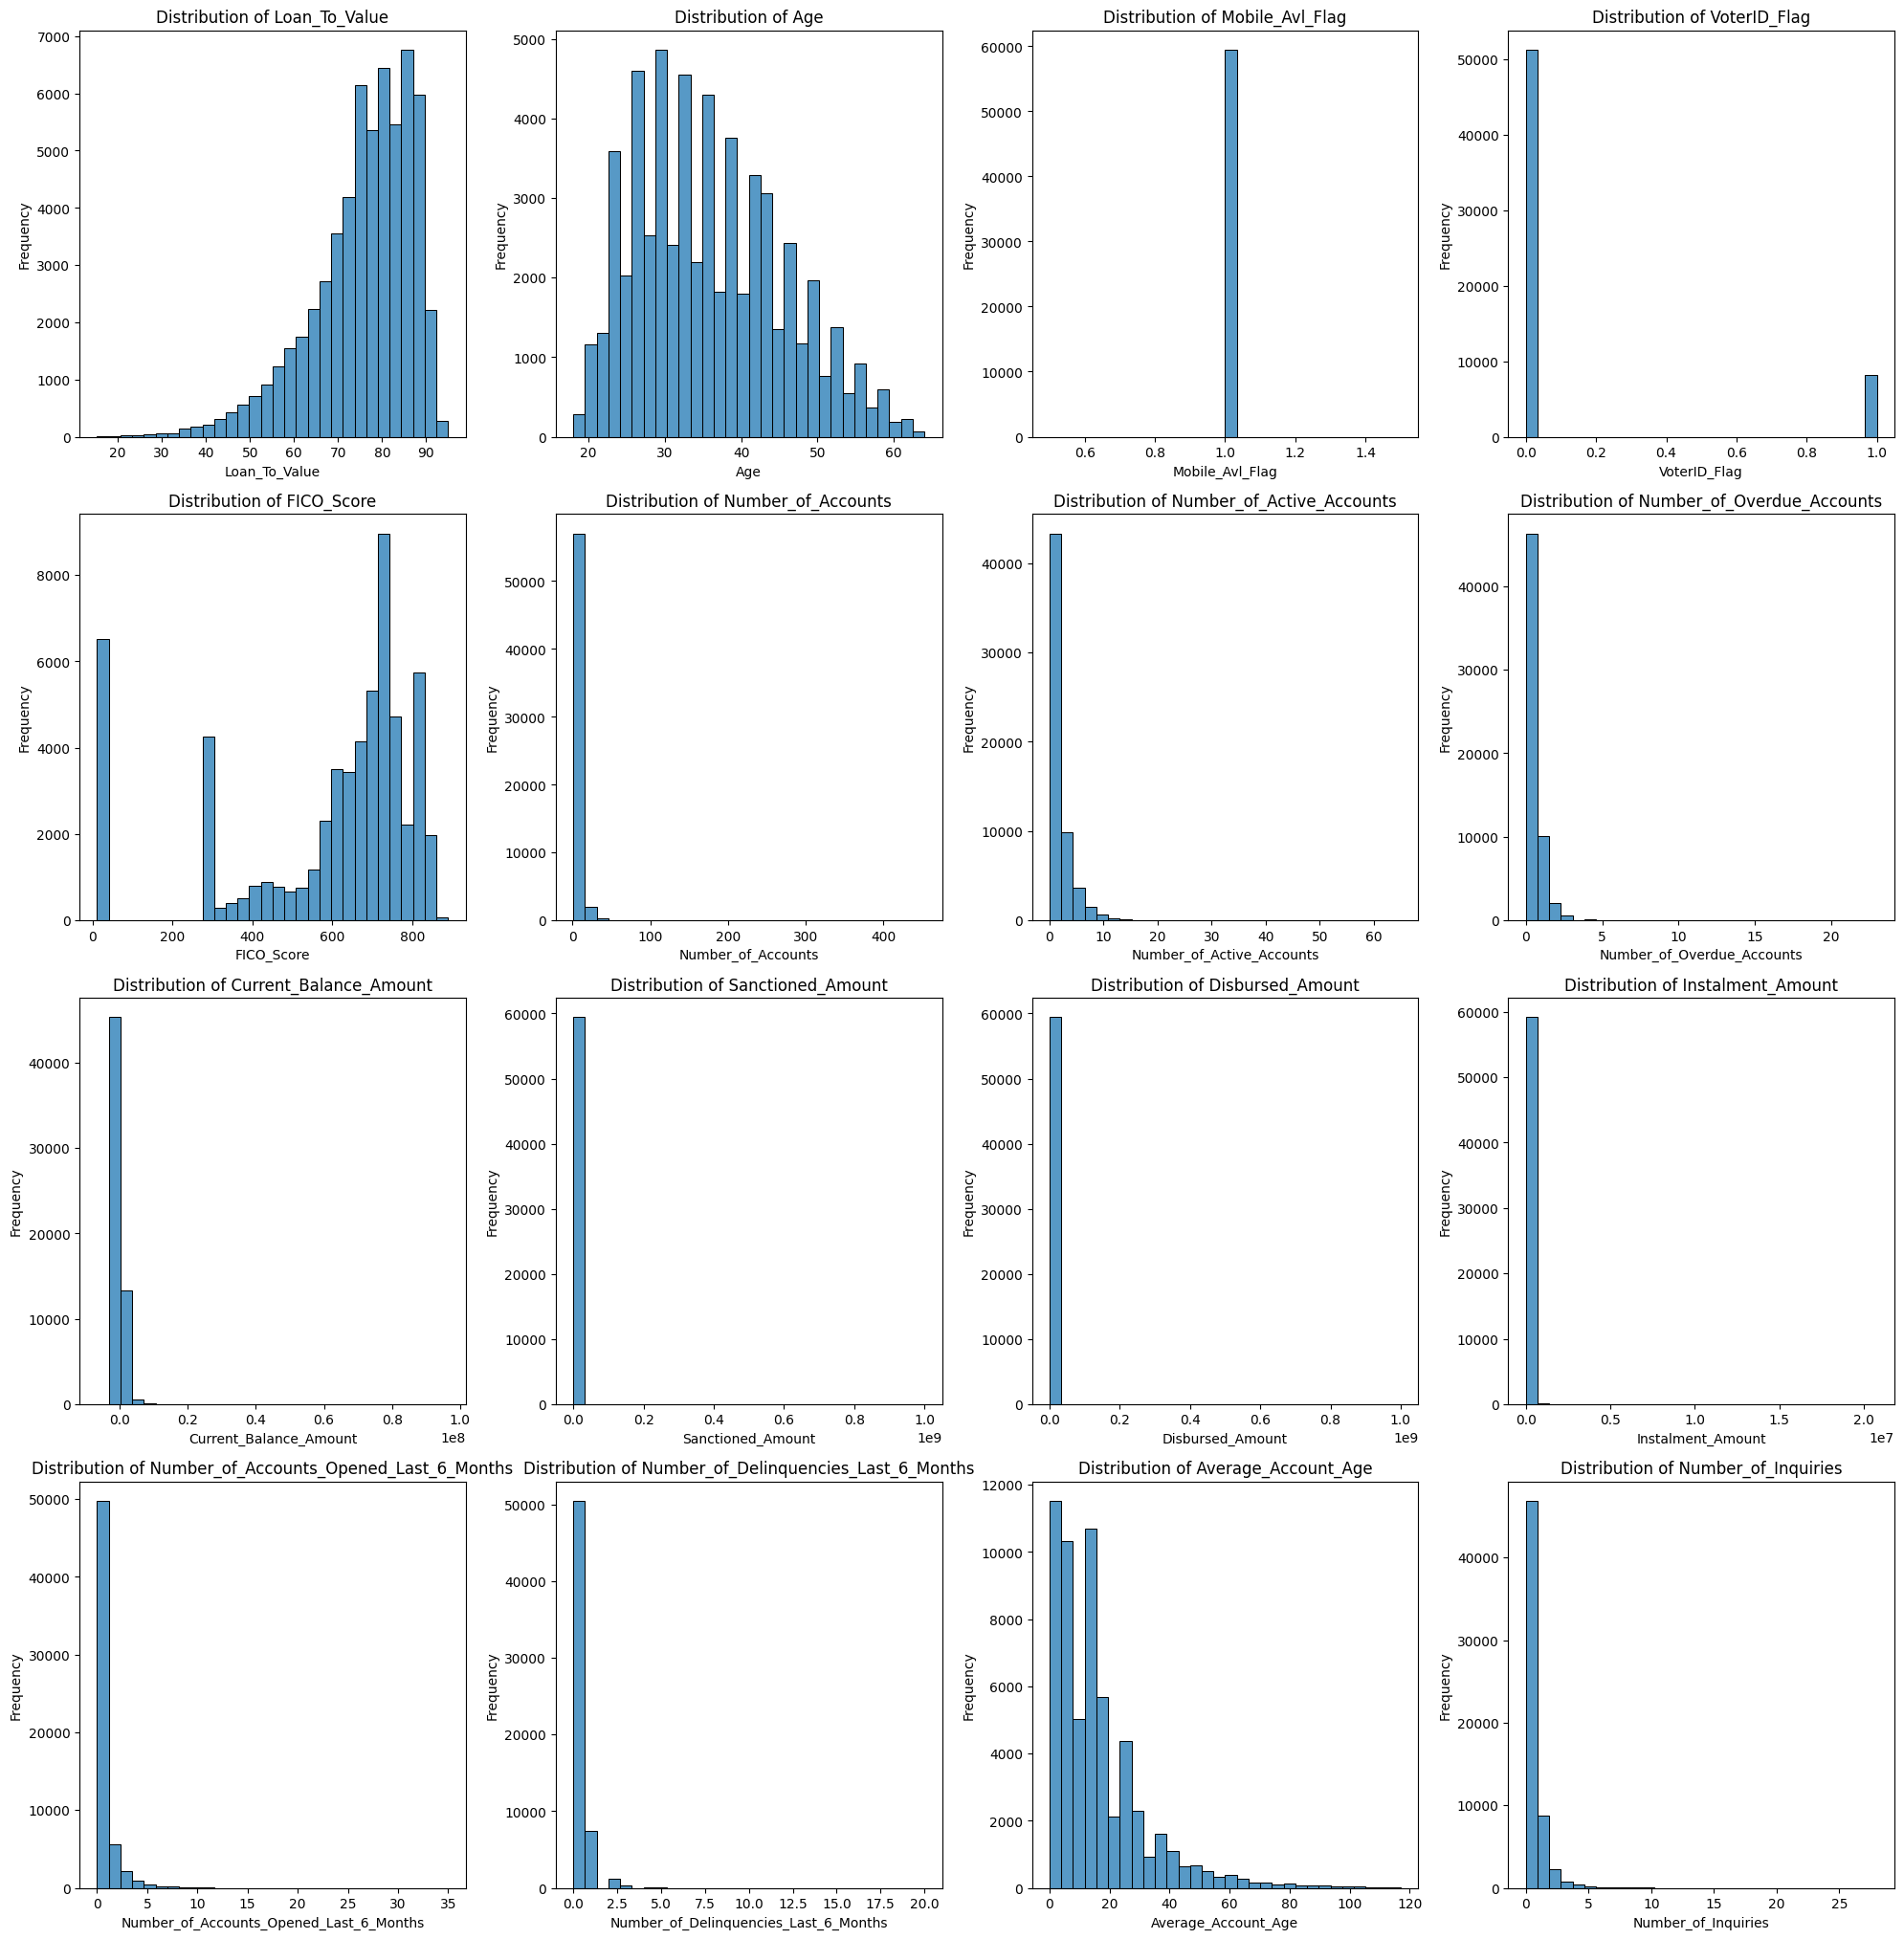

In [10]:
plt.figure(figsize=(20, 25))

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for index, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, index)
    sns.histplot(df[column], bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Observation

#### Numerical features
1. `Loan_To_Value` - Most loans have a higher loan-to-value ratio. This suggests that customers usually borrow a significant portion of the asset's value.

2. `Age` - Age of customers ranges from 18 to 64 years, with the median age being 35 years. The age disttribution is right-skewed. This implies that younger individuals are more common in this dataset.

3. `FICO_Score` - The score ranges from 11 to 890. Large number of customers have scores below 300, which they are Bureau excluded customers. The distribution shows a peak around 750 which is typically considered a good FICO score.

4. `Number_of_Accounts` - Some customers hold up to 453 accounts, which might be an outlier. However, 50% of customers hold 3 or fewer accounts.

5. `Number_of_Active_Accounts` - Some customers have up to 65 accounts, which might also be an outlier. However, most customers have 3 or fewer active accounts.

6. `Number_of_Overdue_Accounts` - Most customers do not have any overdue accounts but there are some customers who have up to 23 overdue accounts.

7. `Current_Balance_Amount` - Majority of customers have up to $180K of balance  but there are some customers with over $96M of balance.

8. `Sanctioned_Amount`, `Disbursed_Amount`, `Instalment_Amount` - These financial metrics have a wide range with some values being abnormally high. This could indicate the presence of outliers or large loan amounts.

9. `Number_of_Accounts_Opened_Last_6_Months` - Most customers haven't opened a new account in the last 6 months. Some customers have opened 35 accounts in the last 6 months, this might be an outlier.

10. `Number_of_Delinquencies_Last_6_Months` - Most customers have no delinquencies in the last 6 months.

11. `Average_Account_Age` - On average, customer accounts are around 16 years old.

12. `Number_of_Inquiries` - Most customers have never made any inquiries.

#### Categorical/Boolean features
1. `Mobile_Avl_Flag` - Most customers do not have a valid mobile contact.

2. `VoterID_Flag` - Most customers are not registered in the electoral roll.

3. `Employment_Type` - Most customers are self-employed.

4. `State` - Most customers are from the state of Louisiana.

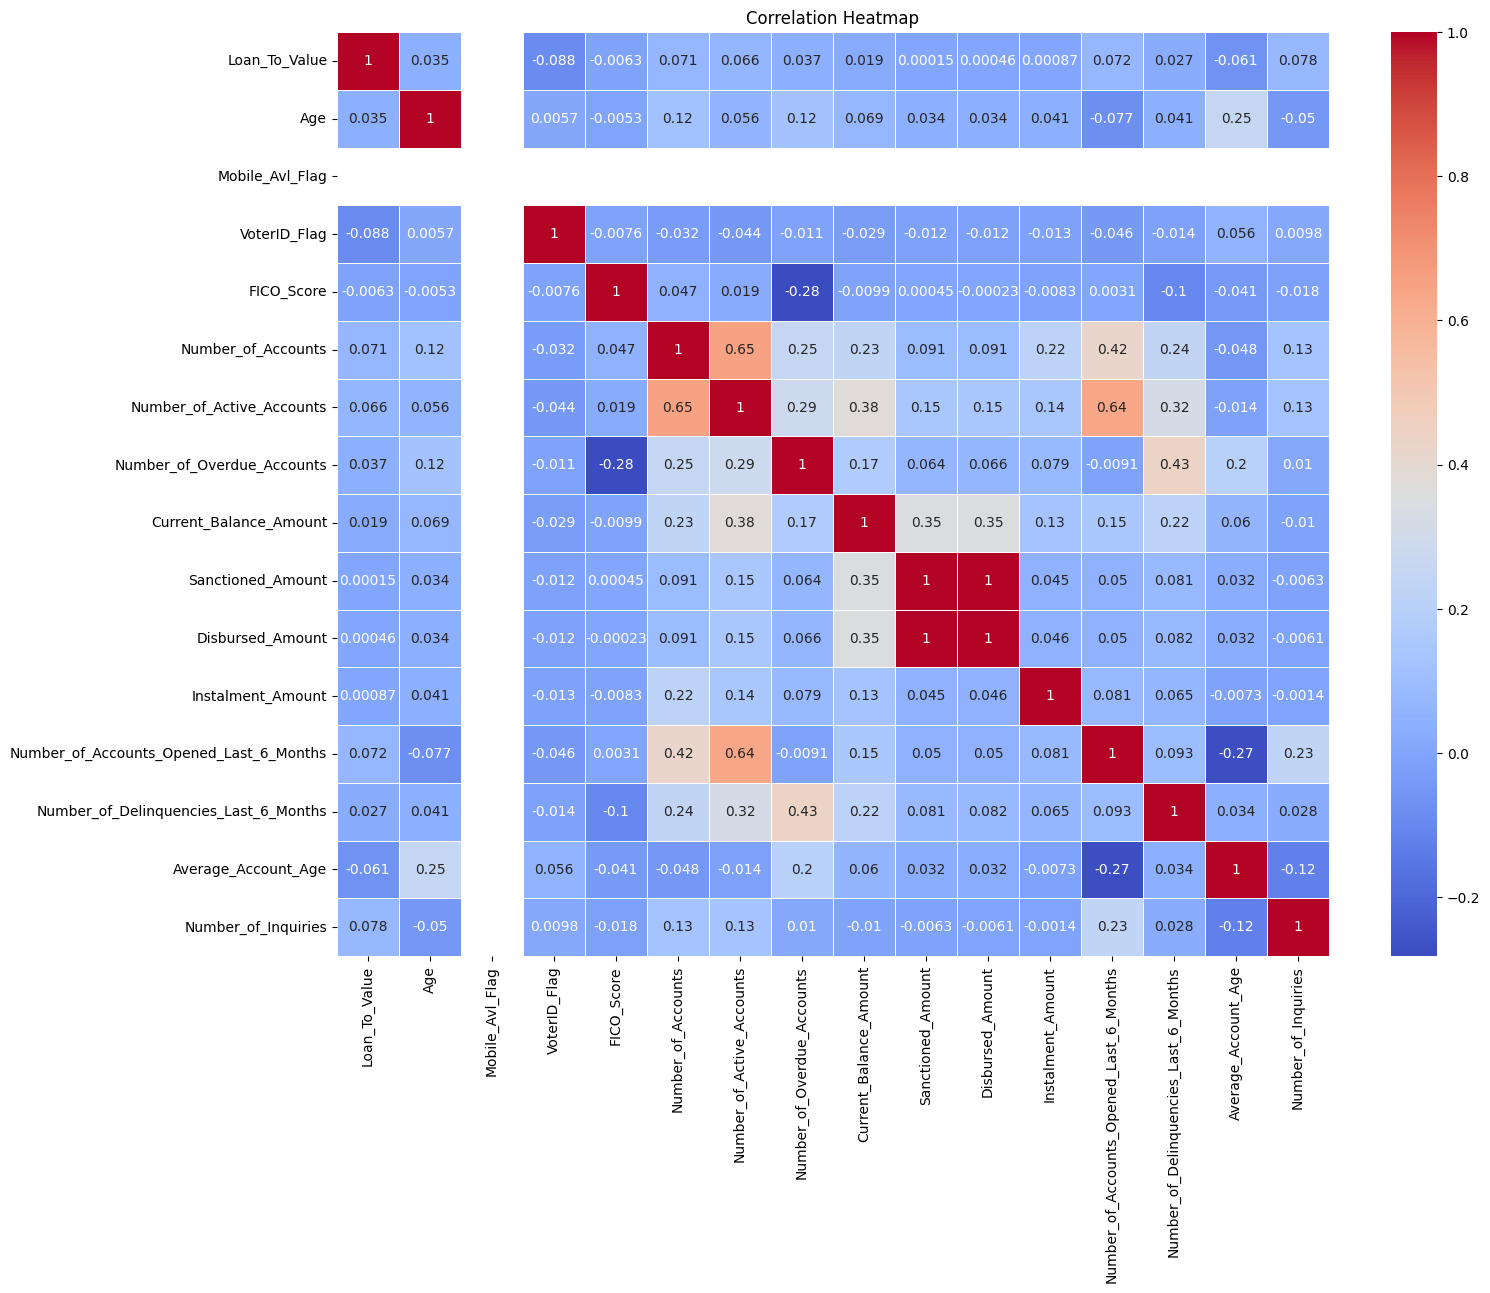

In [11]:
# Correlation analysis
corr_matrix = df.loc[:, ~df.columns.isin(["State", "Employment_Type"])].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

1. `Sanctioned_Amount` and `Disbursed_Amount` have a near perfect positive correlation, which makes sense because the disbursed amount is often close or equal to the amount originally sanctioned.

2. `Number_of_Accounts` and `Number_of_Active_Accounts` have a high positive correlation, indicating that the customers with more accounts tend to have more of those accounts active.

3. `FICO_Score` have a slight negative relation with `Number_of_Overdue_Accounts` and `Number_of_Delinquencies_Last_6_Months`. This makes sense because a lower FICO score (poor credit rating) might be associated with more delinquencies or overdue accounts.

4. `Number_of_Delinquencies_Last_6_Months` and `Number_of_Overdue_Accounts` have a slight positive correlation, suggesting customers who have had delinquencies in the past 6 months are more likely to have overdue accounts.

### Preprocessing

In [12]:
# Drop columns with high cardinality
df.drop(columns=["State"], inplace=True)

# One-Hot encoding
df_encoded = pd.get_dummies(df, columns=["Employment_Type"])
df_encoded[["Employment_Type_Missing", "Employment_Type_Salaried", "Employment_Type_Self employed"]] =\
    df_encoded[["Employment_Type_Missing", "Employment_Type_Salaried", "Employment_Type_Self employed"]].astype(int)
df_encoded

# Normalize features
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
df_normalized

,Loan_To_Value,Age,Mobile_Avl_Flag,VoterID_Flag,FICO_Score,Number_of_Accounts,Number_of_Active_Accounts,Number_of_Overdue_Accounts,Current_Balance_Amount,Sanctioned_Amount,Disbursed_Amount,Instalment_Amount,Number_of_Accounts_Opened_Last_6_Months,Number_of_Delinquencies_Last_6_Months,Average_Account_Age,Number_of_Inquiries,Employment_Type_Missing,Employment_Type_Salaried,Employment_Type_Self employed
0,0.726851,0.326087,0.0,0.0,0.667804,0.000000,0.015385,0.043478,0.064978,0.000050,0.000050,0.000096,0.000000,0.05,0.111111,0.000000,0.0,0.0,1.0
1,0.918193,0.152174,0.0,0.0,0.334471,0.004425,0.000000,0.000000,0.064710,0.000000,0.000000,0.000001,0.000000,0.00,0.068376,0.035714,0.0,0.0,1.0
2,0.932999,0.217391,0.0,0.0,0.926052,0.002212,0.000000,0.000000,0.064710,0.000000,0.000000,0.000065,0.000000,0.00,0.179487,0.000000,0.0,0.0,1.0
3,0.710038,0.239130,0.0,0.0,0.006826,0.000000,0.015385,0.000000,0.065416,0.000075,0.000075,0.000000,0.000000,0.00,0.017094,0.000000,0.0,1.0,0.0
4,0.931744,0.195652,0.0,0.0,0.804323,0.000000,0.015385,0.000000,0.064710,0.000365,0.000365,0.000000,0.000000,0.00,0.478632,0.035714,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59472,0.709159,0.173913,0.0,1.0,0.006826,0.000000,0.015385,0.000000,0.065229,0.000054,0.000054,0.000000,0.028571,0.00,0.000000,0.000000,0.0,0.0,1.0
59473,0.636010,0.326087,0.0,1.0,0.714448,0.000000,0.015385,0.000000,0.066212,0.000225,0.000225,0.000000,0.000000,0.00,0.008547,0.000000,0.0,0.0,1.0
59474,0.651317,0.282609,0.0,1.0,0.827076,0.000000,0.015385,0.000000,0.064931,0.000030,0.000030,0.000077,0.000000,0.00,0.076923,0.000000,0.0,0.0,1.0
59475,0.417691,0.739130,0.0,0.0,0.006826,0.000000,0.015385,0.000000,0.065058,0.000036,0.000036,0.000000,0.028571,0.00,0.000000,0.000000,0.0,0.0,1.0


### Clustering

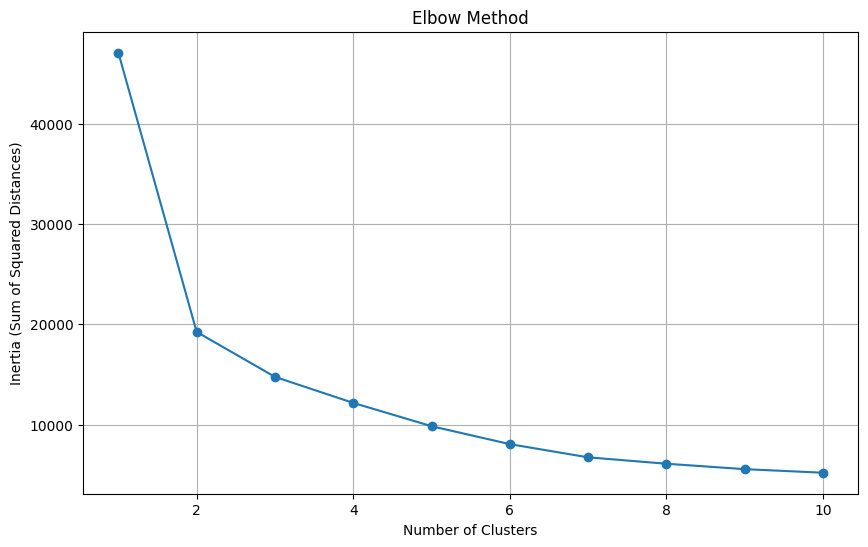

In [13]:
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

Based on the above Elbow method, the appropriate number of cluster for this analysis is 2 (i.e. k = 2).

In [14]:
kmeans = KMeans(n_clusters=2, random_state=2403)
kmeans.fit(df_normalized)

df_encoded['cluster'] = kmeans.labels_
df_encoded

,Loan_To_Value,Age,Mobile_Avl_Flag,VoterID_Flag,FICO_Score,Number_of_Accounts,Number_of_Active_Accounts,Number_of_Overdue_Accounts,Current_Balance_Amount,Sanctioned_Amount,Disbursed_Amount,Instalment_Amount,Number_of_Accounts_Opened_Last_6_Months,Number_of_Delinquencies_Last_6_Months,Average_Account_Age,Number_of_Inquiries,Employment_Type_Missing,Employment_Type_Salaried,Employment_Type_Self employed,cluster
0,73.23,33,1,0,598,1,1.0,1,27600,50200,50200,1991,0,1,13,0,0,0,1,1
1,88.48,25,1,0,305,3,0.0,0,0,0,0,31,0,0,8,1,0,0,1,1
2,89.66,28,1,0,825,2,0.0,0,0,0,0,1347,0,0,21,0,0,0,1,1
3,71.89,29,1,0,17,1,1.0,0,72879,74500,74500,0,0,0,2,0,0,1,0,0
4,89.56,27,1,0,718,1,1.0,0,-41,365384,365384,0,0,0,56,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59472,71.82,26,1,1,17,1,1.0,0,53512,53512,53512,0,1,0,0,0,0,0,1,1
59473,65.99,33,1,1,639,1,1.0,0,155000,225000,225000,0,0,0,1,0,0,0,1,1
59474,67.21,31,1,1,738,1,1.0,0,22779,30000,30000,1600,0,0,9,0,0,0,1,1
59475,48.59,52,1,0,17,1,1.0,0,35895,35895,35895,0,1,0,0,0,0,0,1,1


In [15]:
# Size of each cluster
df_encoded["cluster"].value_counts()

cluster
1    33945
0    25532
Name: count, dtype: int64

In [16]:
# Analyse the clusters
cluster_summary = df_encoded.groupby('cluster').mean()
cluster_summary.transpose()

cluster,0,1
Loan_To_Value,76.352355,75.022154
Age,34.735783,36.782619
Mobile_Avl_Flag,1.000000,1.000000
VoterID_Flag,0.118165,0.153042
FICO_Score,597.534427,576.666254
Number_of_Accounts,4.501802,4.907350
Number_of_Active_Accounts,1.975129,2.080984
Number_of_Overdue_Accounts,0.268565,0.332420
Current_Balance_Amount,267640.904590,360173.366387
Sanctioned_Amount,341120.551778,498293.624009


#### Cluster Observation

1. `Loan_To_Value`: Cluster 0 has a slightly higher average loan-to-value ratio.
2. `Age`: Cluster 0 consists of slightly younger individuals on average.
3. `FICO_Score`: Cluster 0 has a higher average FICO score than Cluster 1.
4. `Number_of_Accounts`: Cluster 0 has a lower average number of accounts.
5. `Number_of_Active_Accounts`: Cluster 0 has fewer active accounts on average.
6. `Number_of_Overdue_Accounts`: Cluster 0 has a lower average number of overdue accounts.
7. `Current_Balance_Amount`: Cluster 0 has a significantly lower average current balance amount.
8. `Sanctioned_Amount`, `Disbursed_Amount`, `Instalment_Amount`: Cluster 0 has a notably lower average sanctioned, disbursed and instalment amounts.
9. `Number_of_Accounts_Opened_Last_6_Months`: Cluster 0 opened fewer accounts in the last 6 months on average.
10. `Number_of_Delinquencies_Last_6_Months`: Cluster 0 has fewer delinquencies in the last 6 months on average.
11. `Average_Account_Age`: Cluster 0 has slightly newer accounts on average.
12. `Number_of_Inquiries`: Cluster 0 has fewer inquiries on average.
13. `Employment_Type`: Customers in Cluster 0 are either salaried or do not have employment type information, while customers in Cluster 1 are mostly self-employed.

##### Cluster Summary

**Cluster 0** seems to represent customers with 
- less credit activity 
- fewer accounts 
- lower balances 
- **lower credit risk**.

**Cluster 1** seems to represent customers with 
- higher credit activity 
- more accounts
- higher balances
- higher number of overdue accounts
- lower FICO scores
- **higher credit risk**